<a href="https://colab.research.google.com/github/lucash-h/GANS/blob/main/MGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The general structure of this MGGAN are as follows


1. An encoder and decoder are built, and defined
2. An autoencoder is built and defined using the encoder and decoder networks (input -> encoder -> decoder -> output)
3. A generator is built and defined
4. Two discriminators, latent and pixel, are built and defined
5. Training step includes the following:<br>
  i. Generator is optimized using both discriminator losses<br>
  ii.the pixel discriminator is optimized on x_train batches and output directly from generator<br>
  iii.the latent discriminator is optimized on x_train batches and generated images, which are both passed through the pre-trained encoder from step 1 & 2.<br>



************************* * * * * * * *   * * * * CHECK * * * * * * * * * * * *

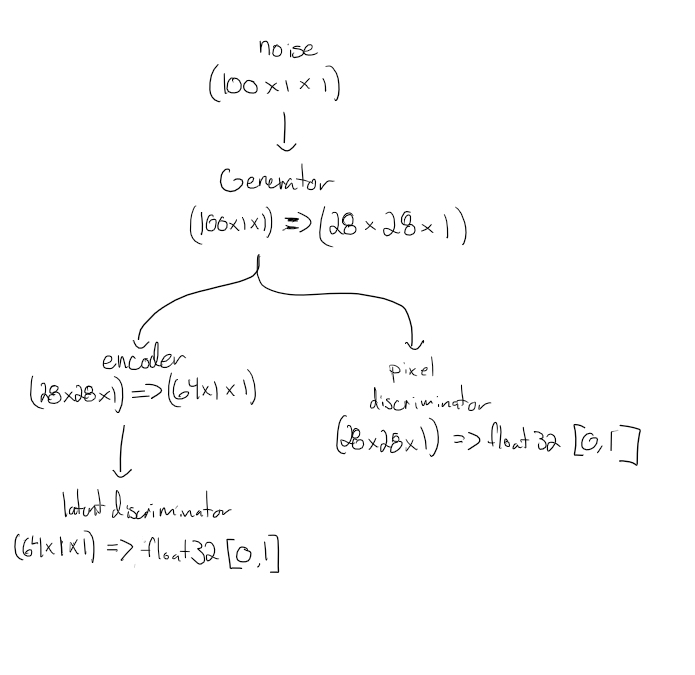

In [ ]:
!pip install tensorflow
!pip install keras
!pip install numpy
!pip install matplotlib
!pip install tqdm

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers, losses, models, optimizers
from tensorflow.keras.layers import Dense, Conv2D, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from tqdm import tqdm

Encoder = E<br>
Decoder = D<br>
Generator = Gen<br>
Pixel Discriminator = p_disc<br>
Latent Discriminator = l_disc

In [216]:
loss_log = {'autoencoder_loss':[],
            'generator_pixel_loss':[],
            'generator_latent_loss':[],
            'total_generator_loss':[],
            'total_pixel_discriminator_loss':[],
            'real_pixel_discriminator_loss':[],
            'fake_pixel_discriminator_loss':[],
            'total_latent_discriminator_loss':[],
            'real_latent_discriminator_loss':[],
            'fake_latent_discriminator_loss':[]}
#add accuracy too maybe? --> currently using evaluate

In [217]:
#Set to true to see model summaries
summaries = False

In [339]:
#Encoder Variables
E_first_dim = 112
E_latent_dim = 64
E_shape = (28, 28, 1)

In [340]:
#Decoder Variables
D_latent_dim = E_latent_dim
D_shape = E_shape

In [341]:
#Autoencoder Variables
autoencoder_epochs = 5
batch_size = 1875
batch_number = 32
learning_rate = 0.001

In [342]:
gan_epochs = 15

In [343]:
(x_train, x_train_labels), (x_test,x_test_lables) = tf.keras.datasets.mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_train_labels.shape == (60000,)

assert x_test.shape == (10000, 28, 28)
assert x_test_lables.shape == (10000,)



x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = tf.reshape(x_train,(batch_number,batch_size,28,28,1))


In [344]:
print(x_train.shape)
print(x_test.shape)

(32, 1875, 28, 28, 1)
(10000, 28, 28)


In [345]:
#build encoder
def build_encoder(shape, first_dim, latent_dim):
    xin = Input(shape)
    xout = Flatten()(xin)
    xout = Dense(first_dim, activation='linear')(xout)
    xout = Dense(latent_dim, activation='relu')(xout)
    return Model(xin, xout, name="Encoder")

In [346]:
encoder = build_encoder(E_shape, E_first_dim, E_latent_dim)

In [347]:
#build decoder
def build_decoder(latent_dim, shape):
    xin = Input(shape=(latent_dim,))
    xout = Dense(tf.math.reduce_prod(shape), activation='sigmoid')(xin)
    xout = Reshape(shape)(xout)
    return Model(xin, xout, name="Decoder")

In [348]:
decoder = build_decoder(D_latent_dim, D_shape)

In [349]:
if(summaries == True):
  encoder.summary()
  decoder.summary()

In [350]:
def build_autoencoder(encoder_model, decoder_model):

    encoder_input = encoder_model.input
    decoder_output = decoder_model(encoder_model.output)

    return Model(inputs=encoder_input, outputs=decoder_output, name="Autoencoder")

In [351]:
autoencoder = build_autoencoder(encoder, decoder)

if(summaries == True):
  autoencoder.summary()

In [352]:
#optimize both models
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [353]:
ms_err = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [354]:
#train step
@tf.function
def autoencoder_train_step(sample):
  autoencoder_log = []
  with tf.GradientTape() as tape:

    reconstructed_images = autoencoder(sample)

    autoencoder_loss = ms_err(sample, reconstructed_images)

    autoencoder_log.append(autoencoder_loss)

  gradient = tape.gradient(autoencoder_loss, autoencoder.trainable_variables)
  optimizer.apply_gradients(zip(gradient,autoencoder.trainable_variables))
  return autoencoder_log

In [355]:
#little function to randomize batch sample taken
def randomize_batch(first_batch, last_batch, dataset):
  rand_index = np.random.randint(0,32)
  sample = x_train[rand_index]
  return sample

In [356]:
#Train
for epoch in range(autoencoder_epochs):
  sample = randomize_batch(0,32,x_train)
  for batch in tqdm(sample):
    loss_list = autoencoder_train_step(sample)
    loss_log['autoencoder_loss'].append(loss_list)

100%|██████████| 1875/1875 [00:04<00:00, 431.04it/s]


In [357]:
#Plot it make sure its working
def show_images(num_images, images, title):
    num_cols = num_images

    fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(12, 6))
    plt.title(title)

    for i in range(num_images):
        axes[0, i].imshow(images[i][:, :, 0], cmap='gray')

In [358]:
def plot_img(n, real_img, real_img_label, fake_img, fake_img_title):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(real_img[i+n * 2])
    plt.title(real_img_label)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(fake_img[i+n * 2])
    plt.title(fake_img_title)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

59/59 [==============================] - 0s 2ms/step


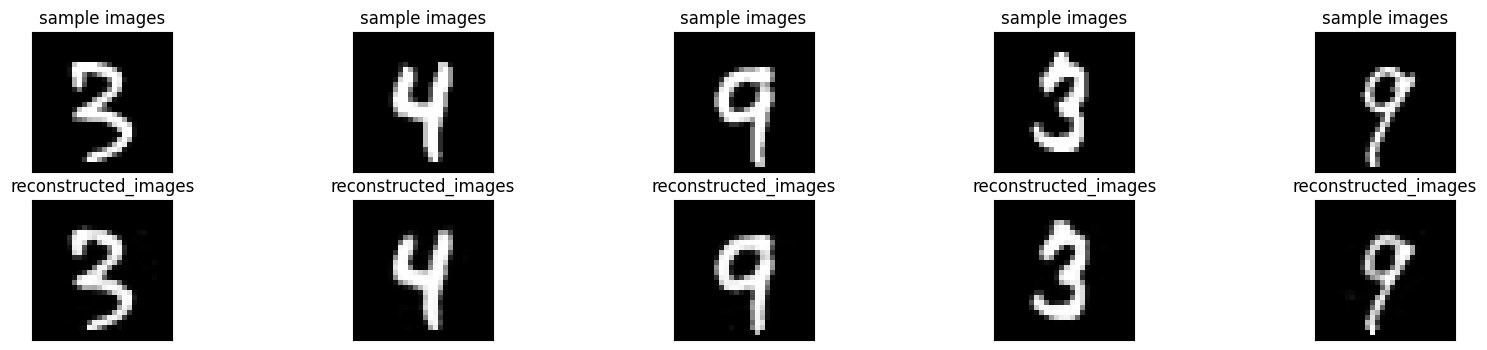

In [359]:
# Plot the first 5 images from x_train
reconstructed_images = autoencoder.predict(sample)

plot_img(5, sample, "sample images", reconstructed_images, "reconstructed_images")

In [360]:
#Generator Variables
noise_dim = 100
gen_learning_rate = 0.001

In [361]:
#pixel discriminator variables
pixel_dim = (28,28,1)
pixel_disc_learning_rate = 0.001

In [362]:
#latent discriminator Variables
latent_dim = (64)
latent_disc_learning_rate = 0.001
batch_size = 1875

In [363]:
#build generator
def build_generator(noise_dim):
  xin = Input((noise_dim))
  xout = Dense(7*7*128, input_dim = noise_dim)(xin) #map input noise to higher dimension
  xout = Reshape((7,7,128))(xout) #reshape so suitable for convolution
  xout = BatchNormalization()(xout) #normalizes
  xout = LeakyReLU(alpha=0.2)(xout) #non linearity
  xout = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(xout) #generate higher res
  xout = BatchNormalization()(xout)
  xout = LeakyReLU(alpha=0.2)(xout)
  xout = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')(xout)
  return Model(xin,xout,name="Generator")

In [364]:
generator = build_generator(noise_dim)

In [365]:
if(summaries == True):
  generator.summary()

In [366]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate)

In [367]:
gen_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [368]:
generator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=gen_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [369]:
#build pixel discriminator(recceives 28*28*1)
def build_pixel_discriminator(pixel_dim):

    xin = Input((pixel_dim))
    xout = Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=pixel_dim)(xin)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(xout)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Flatten()(xout)
    xout = Dense(1, activation='sigmoid')(xout)

    return Model(xin,xout, name="Pixel_Discriminator")

In [370]:
pixel_discriminator = build_pixel_discriminator(pixel_dim)

In [371]:
if(summaries == True):
  pixel_discriminator.summary()

In [372]:
pixel_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=pixel_disc_learning_rate)

In [373]:
pixel_disc_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [374]:
pixel_discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=pixel_disc_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [375]:
#build latent discriminator(receives 64*1*1)
def build_latent_discriminator(latent_dim):
    xin = Input(latent_dim)
    xout = Reshape((64,1,1))(xin)
    xout = Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 1, 1))(xout) #could just change this layer to accept 64,1,1 input shape and remove reshape
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(xout)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Flatten()(xout)
    xout = Dense(1, activation='sigmoid')(xout) #sets vals 0-1 --> fake - real

    return Model(xin,xout, name="Latent_Discriminator")

In [376]:
latent_discriminator = build_latent_discriminator(latent_dim)

In [377]:
if(summaries == True):
  latent_discriminator.summary()

In [378]:
latent_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=latent_disc_learning_rate)
latent_disc_bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [379]:
latent_discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=latent_disc_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

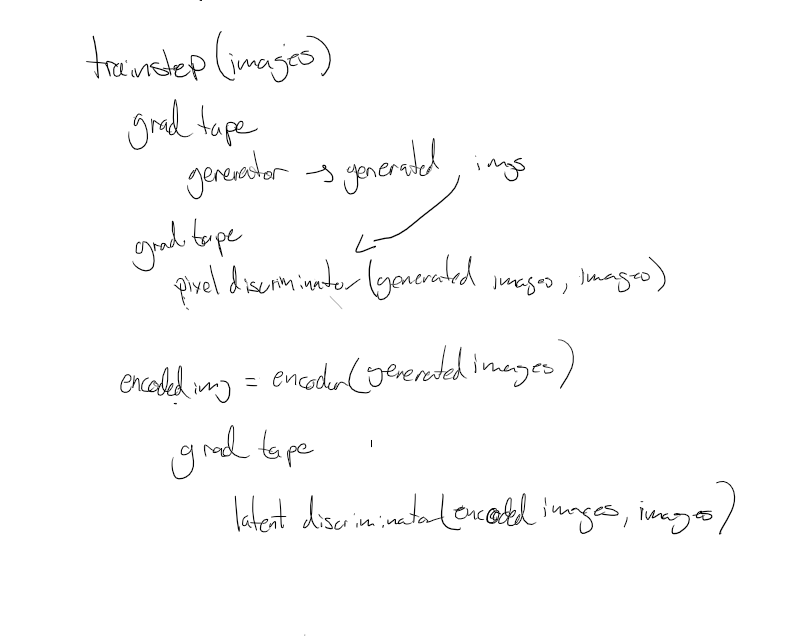

In [380]:
'''Gradient tape for generator'''
@tf.function

def generator_train_step(images, noise):
  pixel_generator_loss_log = []
  latent_generator_loss_log = []
  total_generator_loss_log = []


  with tf.GradientTape() as gen_tape:

    #running respective images through discriminator to determine discriminator differences from ones(what the image actually is)
    generated_images = generator(noise)
    fake_pixel_output = pixel_discriminator(generated_images)
    generator_pixel_loss = gen_bce(tf.ones_like(fake_pixel_output, dtype = tf.float32),fake_pixel_output)

    pixel_generator_loss_log.append(generator_pixel_loss)

    new_images = tf.reshape(images, (-1, 28, 28, 1))  # Add batch dimension

    encoded_output = encoder(new_images)
    fake_latent_output = latent_discriminator(encoded_output)
    generator_latent_loss = gen_bce(tf.ones_like(fake_latent_output,dtype = tf.float32), fake_latent_output)

    latent_generator_loss_log.append(generator_latent_loss)

    #generator_log['generator_pixel_loss'].append(generator_pixel_loss)
    #generator_log['generator_latent_loss'].append(generator_latent_loss)


    total_generator_loss = (generator_pixel_loss + generator_latent_loss) / 2 #should maybe change if gradient permits or weight it?
    #generator_log['total_generator_loss'].append(total_generator_loss)

    total_generator_loss_log.append(total_generator_loss)

  gradients_of_generator = gen_tape.gradient(total_generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  return pixel_generator_loss_log, latent_generator_loss_log, total_generator_loss_log

In [381]:
'''Gradient tape for pixel discriminator'''
@tf.function


def pixel_discriminator_train_step(images, generated_images):
  pixel_discriminator_log = {'total_pixel_discriminator_loss':[],
                          'real_pixel_discriminator_loss':[],
                          'fake_pixel_discriminator_loss':[]}
  fake_pixel_discriminator_loss_log = []
  real_pixel_discriminator_loss_log = []
  total_pixel_discriminator_loss_log = []


  #generated_image = generated_images[0]
  with tf.GradientTape() as pixel_disc_tape:
    new_images = tf.reshape(images, (-1, 28, 28, 1))  # Add batch dimension
    real_output = pixel_discriminator(new_images)
    fake_output = pixel_discriminator(generated_images)
    zeros = tf.zeros(batch_size)
    fake_pixel_discriminator_loss = pixel_disc_bce(tf.zeros_like(fake_output),fake_output)

    #pixel_discriminator_log['fake_pixel_discriminator_loss'].append(fake_pixel_discriminator_loss)
    fake_pixel_discriminator_loss_log.append(fake_pixel_discriminator_loss)

    real_pixel_discriminator_loss = pixel_disc_bce(tf.ones_like(real_output), real_output)
    #pixel_discriminator_log['real_pixel_discriminator_loss'].append(real_pixel_discriminator_loss)
    real_pixel_discriminator_loss_log.append(real_pixel_discriminator_loss)

    total_pixel_discriminator_loss = fake_pixel_discriminator_loss + real_pixel_discriminator_loss
    #pixel_discriminator_log['total_pixel_discriminator_loss'].append(total_pixel_discriminator_loss)
    total_pixel_discriminator_loss_log.append(total_pixel_discriminator_loss)

  gradients_of_pixel_discriminator = pixel_disc_tape.gradient(total_pixel_discriminator_loss, pixel_discriminator.trainable_variables)
  pixel_discriminator_optimizer.apply_gradients(zip(gradients_of_pixel_discriminator, pixel_discriminator.trainable_variables))

  return fake_pixel_discriminator_loss_log, real_pixel_discriminator_loss_log, total_pixel_discriminator_loss_log

In [382]:
'''Gradient tape for latent discriminator'''
@tf.function
def latent_discriminator_train_step(images, generated_images, encoder):
  fake_latent_discriminator_loss_log = [];
  real_latent_discriminator_loss_log = [];
  total_latent_discriminator_loss_log = [];
  latent_disc_log = {
            'total_latent_discriminator_loss':[],
            'real_latent_discriminator_loss':[],
            'fake_latent_discriminator_loss':[]}

  with tf.GradientTape() as latent_disc_tape:
      new_images = tf.reshape(images, (-1, 28, 28, 1))  # Add batch dimension

      real_output = latent_discriminator(encoder(new_images))
      fake_output = latent_discriminator(encoder(generated_images))

      fake_latent_discriminator_loss = latent_disc_bce(tf.zeros_like(fake_output),fake_output)
      #latent_disc_log['fake_latent_discriminator_loss'].append(fake_latent_discriminator_loss)
      fake_latent_discriminator_loss_log.append(fake_latent_discriminator_loss)
      real_latent_discriminator_loss = latent_disc_bce(tf.ones_like(real_output),real_output)
      #latent_disc_log['real_latent_discriminator_loss'].append(real_latent_discriminator_loss)
      real_latent_discriminator_loss_log.append(real_latent_discriminator_loss)

      total_latent_discriminator_loss = fake_latent_discriminator_loss + real_latent_discriminator_loss
      #latent_disc_log['total_latent_discriminator_loss'].append(total_latent_discriminator_loss)
      total_latent_discriminator_loss_log.append(total_latent_discriminator_loss)

  gradients_of_latent_discriminator = latent_disc_tape.gradient(total_latent_discriminator_loss, latent_discriminator.trainable_variables)
  latent_discriminator_optimizer.apply_gradients(zip(gradients_of_latent_discriminator, latent_discriminator.trainable_variables))

  return fake_latent_discriminator_loss_log, real_latent_discriminator_loss_log, total_latent_discriminator_loss_log

In [383]:
def check_and_reshape_input(noise_dim,batch_number, batch_size, encoder, generator, x_train):
  noise = tf.random.normal([1,noise_dim])
  #print(noise.shape)
  generated_images = generator(noise)
  #print(generated_images.shape)
  encoded_generated_images = encoder(generated_images)
  #print(encoded_generated_images.shape)

  #print(x_train.shape)
  rand_int = np.random.randint(0,32)
  encoded_real_images = encoder(x_train[rand_int])
  #print(encoded_real_images.shape)

  rand_int = np.random.randint(0,batch_number)
  test_real_image = x_train[rand_int]
  #print(test_real_image.shape)
  rand_int = np.random.randint(0,batch_size)
  test_real_image = test_real_image[rand_int]
  #print(test_real_image.shape)

  return noise, encoded_generated_images, encoded_real_images, test_real_image, generated_images


In [384]:
#collecting all train steps
#@tf.function
#I may have had to reshape images, or batch due to this...definitely review
def setup(batch, batch_size):
  #noise = tf.random.normal([batch_size,noise_dim])
  noise, encoded_generated_images, encoded_real_images, test_real_image, generated_images = check_and_reshape_input(noise_dim,
                                                                                                  batch_number,
                                                                                                  batch_size,
                                                                                                  encoder,
                                                                                                  generator,
                                                                                                  x_train)
  return noise, encoded_generated_images, encoded_real_images, test_real_image, generated_images

In [385]:
if(summaries == True):
  generator.summary()
  encoder.summary()
  latent_discriminator.summary()

In [386]:
if(summaries == True):
  generator.summary()
  pixel_discriminator.summary()

In [387]:
for epoch in range(gan_epochs):
  sample = randomize_batch(0,32,x_train)
  for batch in tqdm(sample):
      noise, encoded_generated_images, encoded_real_images, test_real_image, generated_images = setup(batch, batch_size)

      generator_losses= generator_train_step(batch, noise)
      pdl = pixel_discriminator_train_step(batch, generated_images)
      ldl = latent_discriminator_train_step(batch, generated_images, encoder)
      #gen_log = generator_train_step(batch, noise)
  #print(generator_losses[0])
  #print(generator_losses[0][0])
  #print(generator_losses[0][0].numpy())

  loss_log['generator_pixel_loss'].append(generator_losses[0][0].numpy())
  loss_log['generator_latent_loss'].append(generator_losses[1][0].numpy())
  loss_log['total_generator_loss'].append(generator_losses[2][0].numpy())

  #print(pdl[0])
  #print(pdl[0][0])
  #print(pdl[0][0].numpy())


  #pixel_disc_log = pixel_discriminator_train_step(batch, generated_images)
  loss_log['fake_pixel_discriminator_loss'].append(pdl[0][0].numpy())
  loss_log['real_pixel_discriminator_loss'].append(pdl[1][0].numpy())
  loss_log['total_pixel_discriminator_loss'].append(pdl[2][0].numpy())

  #print(ldl[0])
  #print(ldl[0][0])
  #print(ldl[0][0].numpy())

  loss_log['fake_latent_discriminator_loss'].append(ldl[0][0].numpy())
  loss_log['real_latent_discriminator_loss'].append(ldl[1][0].numpy())
  loss_log['total_latent_discriminator_loss'].append(ldl[2][0].numpy())




100%|██████████| 1875/1875 [00:45<00:00, 41.48it/s]


In [388]:
def show_images(sample_number, images):

    _edge_length = int(np.sqrt(sample_number))
    fig,ax = plt.subplots(nrows = _edge_length, ncols = _edge_length,figsize=(10,10))
    for i in range(_edge_length**2):

        ax[i//_edge_length][i%_edge_length].imshow(images[i, :, :, 0])
        ax[i//8][i%8].axis('off')

In [389]:
n_generated_samples = 64
generated = generator(tf.random.normal((n_generated_samples,100)))

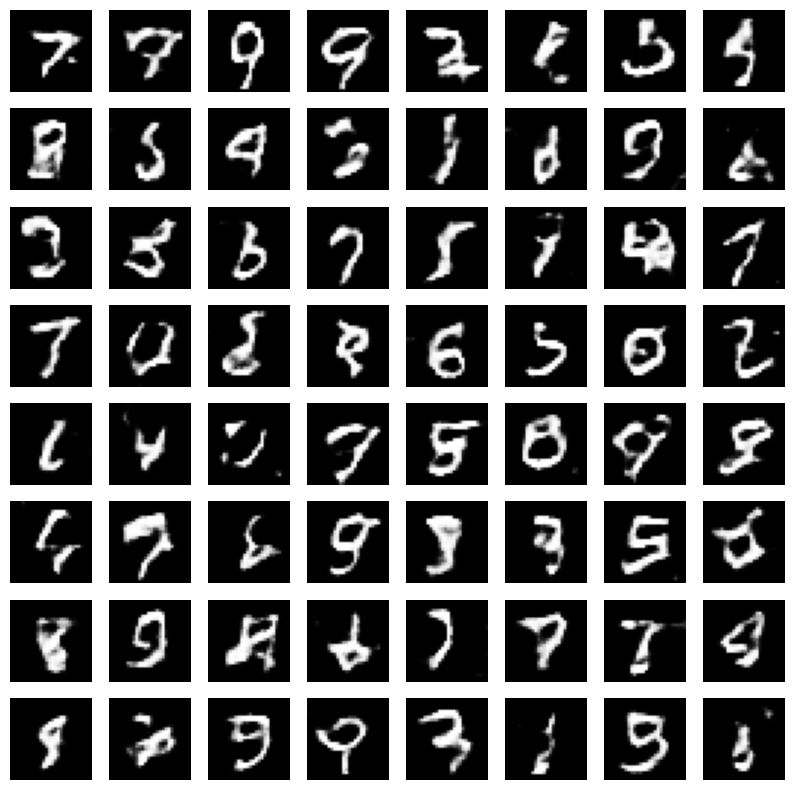

In [390]:
show_images(n_generated_samples, generated)

In [391]:
def plot_metrics(list1,list1_title, list2, list2_title, downsample=False, ds_value=1, x_title='X', y_title='Y', plot_title='Plot'):

    if downsample == True:
        list1 = list1[::ds_value]
        list2 = list2[::ds_value]

    plt.figure().set_figwidth(15)
    plt.grid(True)

    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(plot_title)

    plt.plot(list1, label=list1_title)
    plt.plot(list2, label=list2_title)

    plt.legend()
    plt.show()

In [392]:
print(loss_log['generator_pixel_loss'])
print(loss_log['generator_latent_loss'])


[1.5322549, 0.8024628, 0.31255922, 1.9214245, 4.276019, 3.1614766, 2.4877617, 0.8514608, 1.2948474, 1.1330428, 1.3957064, 2.0428421, 1.3978906, 1.2027855, 2.5164785, 2.7704651, 1.9572985, 2.7964554, 2.1126244, 4.106341, 0.77058953, 1.9914865, 1.4061584, 0.5219119, 2.099055, 1.5526778, 1.1830983, 1.2932193, 0.6126695, 1.7746422, 1.2861391, 0.6919796, 2.4783359, 1.6392746, 2.9539251, 3.271976]
[0.35433683, 0.16493148, 0.1118817, 1.2396789, 0.06905967, 1.5328707, 0.038578443, 1.3229214, 0.014015822, 0.045799866, 0.13816519, 0.6261707, 0.34225598, 0.031160899, 2.1401348, 0.49541724, 0.5126526, 0.5188883, 0.22222462, 0.44262984, 0.14795236, 0.40153518, 0.30206576, 1.12025, 0.2802319, 0.30372903, 0.6347975, 0.008873728, 1.4763161, 0.17049406, 0.73833543, 0.3732079, 0.4337342, 0.10713366, 0.05165589, 0.22592854]


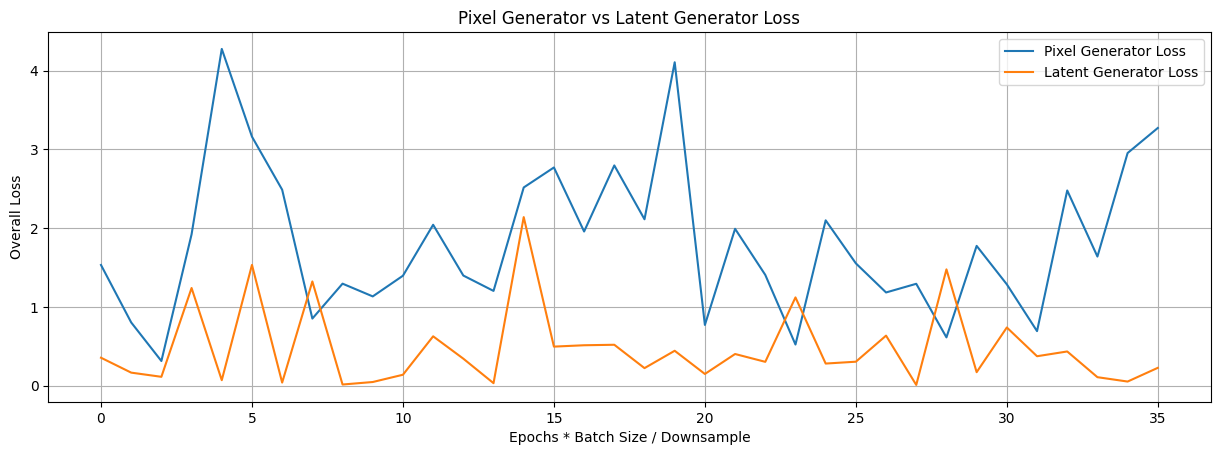

In [393]:
plot_metrics(loss_log['generator_pixel_loss'],
              'Pixel Generator Loss',
              loss_log['generator_latent_loss'],
              'Latent Generator Loss',
              False,
              x_title='Epochs * Batch Size / Downsample',
              y_title ='Overall Loss',
              plot_title = 'Pixel Generator vs Latent Generator Loss')

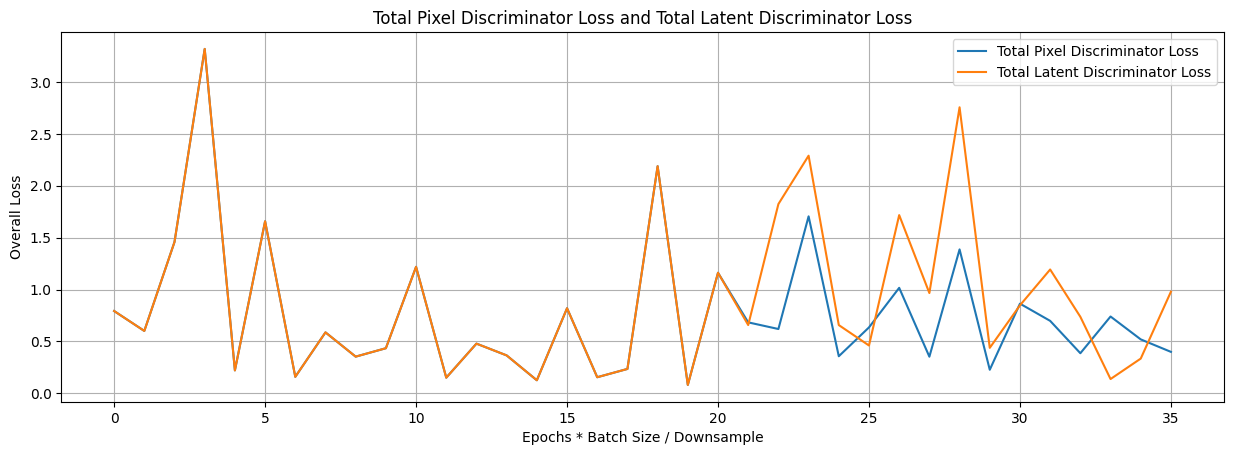

In [394]:
plot_metrics(loss_log['total_pixel_discriminator_loss'],
              'Total Pixel Discriminator Loss',
              loss_log['total_latent_discriminator_loss'],
              'Total Latent Discriminator Loss',
              False,
              x_title='Epochs * Batch Size / Downsample',
              y_title ='Overall Loss',
              plot_title = 'Total Pixel Discriminator Loss and Total Latent Discriminator Loss')


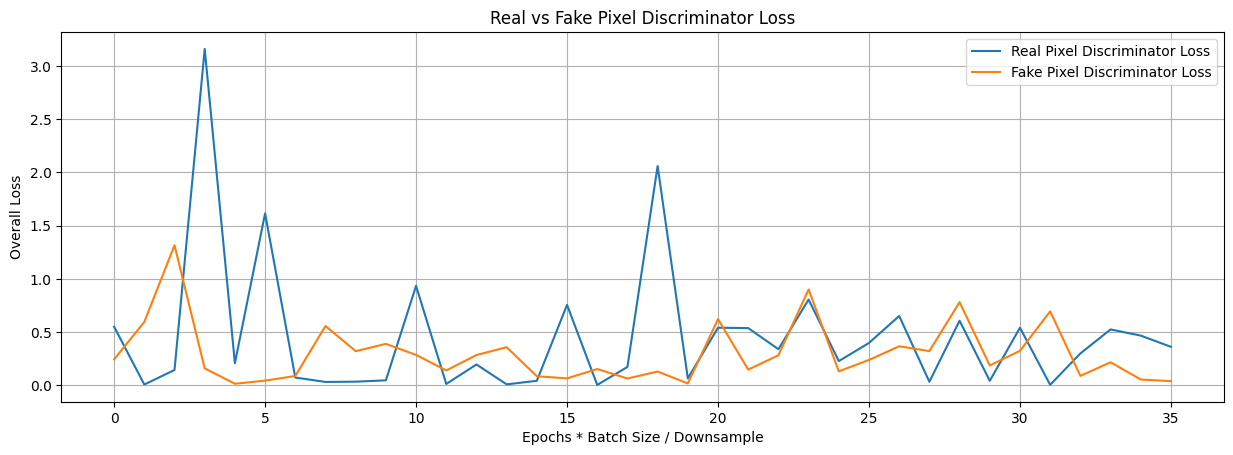

In [395]:
plot_metrics(loss_log['real_pixel_discriminator_loss'],
              'Real Pixel Discriminator Loss',
              loss_log['fake_pixel_discriminator_loss'],
              'Fake Pixel Discriminator Loss',
              False,
              x_title='Epochs * Batch Size / Downsample',
              y_title ='Overall Loss',
              plot_title = 'Real vs Fake Pixel Discriminator Loss')


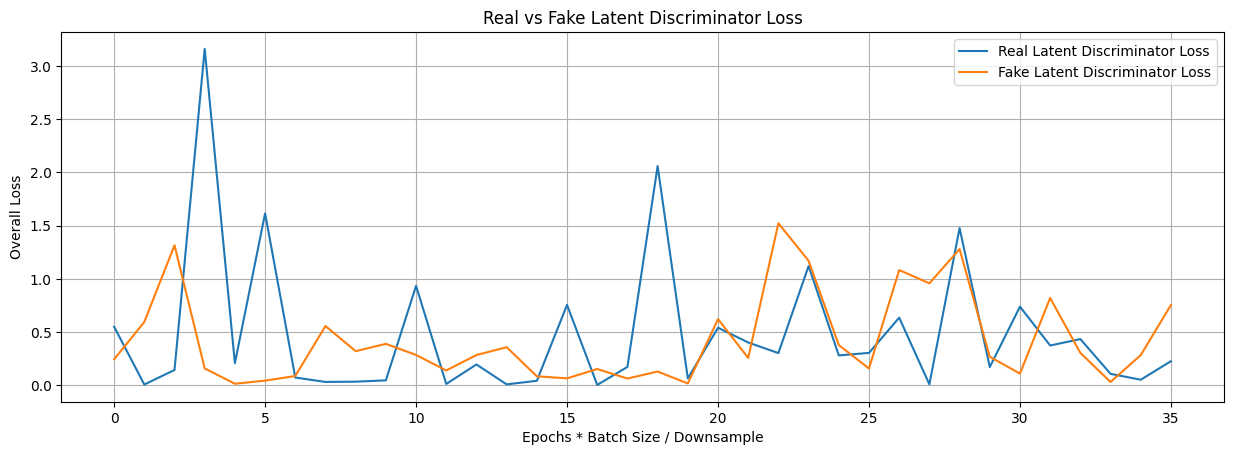

In [396]:
plot_metrics(loss_log['real_latent_discriminator_loss'],
              'Real Latent Discriminator Loss',
              loss_log['fake_latent_discriminator_loss'],
              'Fake Latent Discriminator Loss',
              False,
              x_title='Epochs * Batch Size / Downsample',
              y_title ='Overall Loss',
              plot_title = 'Real vs Fake Latent Discriminator Loss')
